# pvanalytics

In [1]:
from utils import get_analytics_data
import matplotlib.pyplot as plt

In [2]:
df = get_analytics_data('pvanalytics')
print(df['Date'].min().strftime('%Y-%m-%d'), 'to', df['Date'].max().strftime('%Y-%m-%d'))

2022-06-15 to 2022-10-13


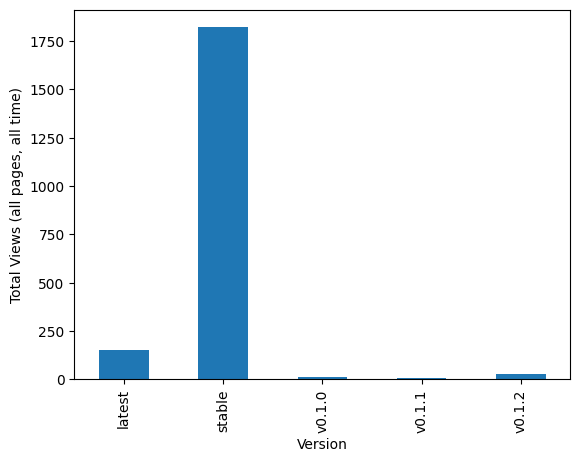

In [3]:
df.groupby('Version')['Views'].sum().plot.bar()
plt.ylabel('Total Views (all pages, all time)')
plt.show()

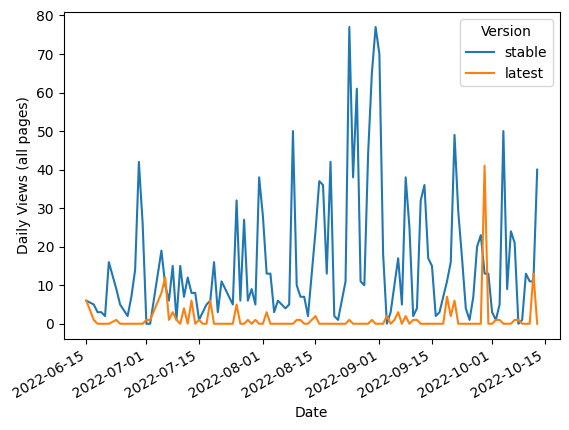

In [4]:
df.pivot_table(values='Views', index='Date', columns='Version', aggfunc='sum')[['stable', 'latest']].fillna(0).plot()
plt.ylabel('Daily Views (all pages)')
plt.show()

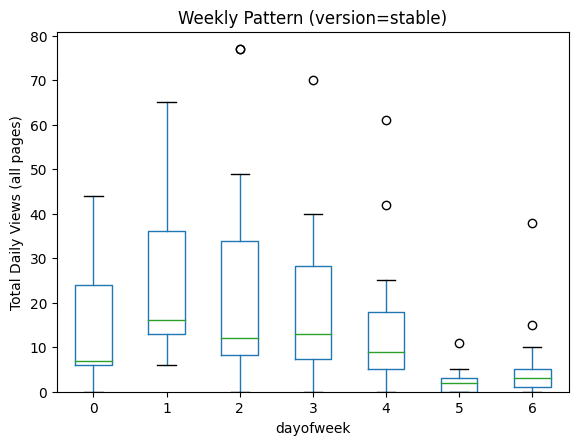

In [5]:
daily = df.loc[df['Version'] == 'stable', :].set_index('Date')['Views'].resample('d').sum()
daily.to_frame().assign(dayofweek=daily.index.dayofweek).boxplot('Views', by='dayofweek', grid=False)
plt.ylim(bottom=0)
plt.ylabel('Total Daily Views (all pages)')
plt.title('Weekly Pattern (version=stable)')
plt.suptitle('')
plt.show()

In [6]:
df2 = df.loc[df['Version'] == 'stable', :].copy()
pathviews = df2.groupby('Path')['Views'].sum()

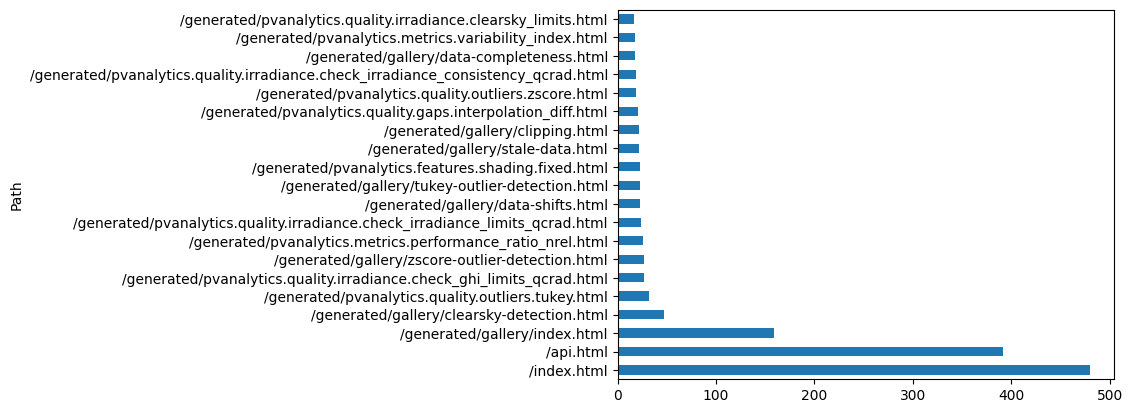

In [7]:
pathviews.sort_values(ascending=False)[:20].plot.barh()
plt.show()

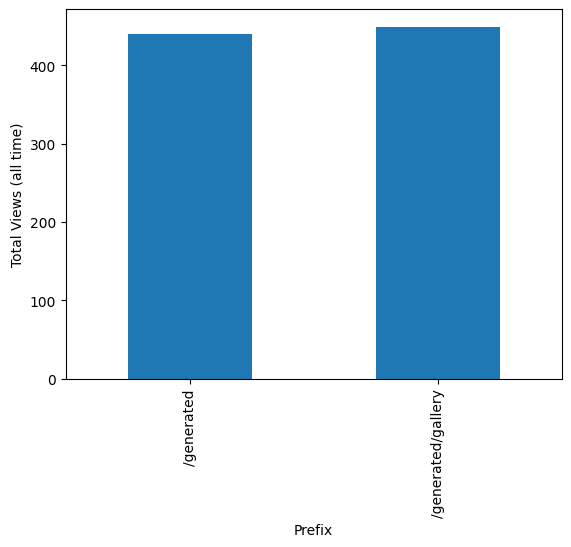

In [8]:
prefixes = ['/generated', '/generated/gallery']
df3 = pathviews.to_frame().reset_index()
df3['Prefix'] = df3['Path'].str.rsplit("/", 1).str[0]
df3.loc[df3['Prefix'].isin(prefixes), :].groupby('Prefix')['Views'].sum().loc[prefixes].sort_values().plot.bar()
plt.ylabel('Total Views (all time)')
plt.show()

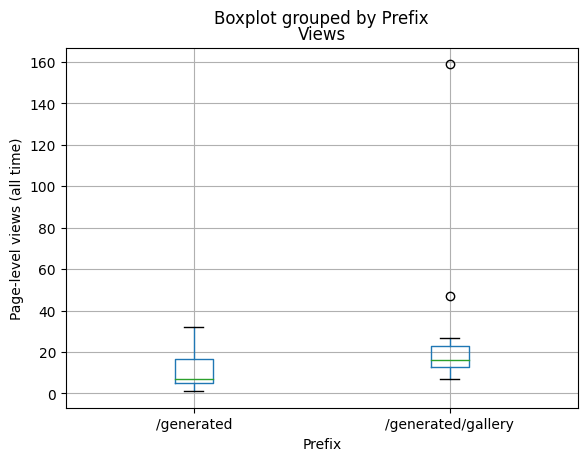

In [9]:
df3.loc[df3['Prefix'].isin(prefixes), :].boxplot('Views', by='Prefix')
plt.ylabel('Page-level views (all time)')
plt.show()